# Pacotes

In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Definir a seed para reprodutibilidade
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

initializer = tf.keras.initializers.GlorotUniform(seed=seed)

tf.config.experimental.enable_op_determinism()


2025-03-08 19:49:55.848167: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 19:49:55.852963: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 19:49:55.884714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741463395.936556   28843 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741463395.955062   28843 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 19:49:56.004534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Importa Dados

In [2]:
# Carregar os dados
data = pd.read_csv("/workspaces/usp-dsa-ann/data/PETR4.SA.csv")

# ERRATA: a correção anteriormente sugerida por meio do sort_values altera
# a estrutura do DataFrame e não fica compatível com o treinamento e teste
# da série temporal. A correção será feita na função shift da célula abaixo.

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-14,29.170000,29.670000,28.719999,29.450001,23.936726,50745400
1,2021-01-15,29.049999,29.080000,28.030001,28.120001,22.855711,80673300
2,2021-01-18,28.309999,28.850000,28.010000,28.070000,22.815071,68855700
3,2021-01-19,28.480000,28.860001,27.639999,28.690001,23.319004,61656000
4,2021-01-20,28.950001,29.120001,28.110001,28.209999,22.928862,60306200


# Cria DF

In [5]:
# Criar as features e o target
fechamento = data["Close"].values
fechamento_anterior = data['Close'].shift(1)

# CORREÇÃO: o shift foi alterado de -1 para 1.
# Desta forma, a defasagem de X em relação a Y fica adequada.

data_analise = pd.DataFrame({"fechamento": fechamento, "fechamento_anterior": fechamento_anterior})
data_analise.dropna(inplace=True)

In [6]:
data_analise.head()

,fechamento,fechamento_anterior
1,28.120001,29.450001
2,28.070000,28.120001
3,28.690001,28.070000
4,28.209999,28.690001
5,27.549999,28.209999


# Pré-processamento

In [7]:
# Normalizar os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(data_analise["fechamento_anterior"].values.reshape(-1, 1))
Y = scaler.fit_transform(data_analise["fechamento"].values.reshape(-1, 1))

In [8]:
# Dividir em conjunto de treinamento e teste
train_size = 150
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

Para trabalhar com estes dados, eles precisam entrar com as informações sobre `batch_size` , `time_steps` e `features`.

In [9]:
# Reshape dos dados para RNN
x_train_rnn = X_train.reshape(10, 15, 1) # batch_size = 10, time_steps = 15, features = 1
y_train_rnn = Y_train.reshape(10, 15, 1)
# Test set
x_test_rnn = X_test.reshape(1, 98, 1)
y_test_rnn = Y_test.reshape(1, 98, 1)

In [10]:
X.shape

(248, 1)

In [11]:
X_train.shape

(150, 1)

In [12]:
X_test.shape

(98, 1)

# Modelo LSTM

In [13]:
# Definir a semente para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [14]:
# Criar o modelo LSTM
model = Sequential([
    LSTM(units=20, activation = 'relu', return_sequences=True, input_shape=(15, 1)),
    Dense(units=10, activation = 'linear'),
    Dense(1)
])

2025-03-08 20:04:49.142567: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compila e Treina

In [15]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compilar modelo
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Treinar o modelo
history = model.fit(x_train_rnn, y_train_rnn, epochs=1000, verbose=1)

Epoch 1/1000


2025-03-08 20:05:24.600785: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2676
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2664
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2651
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2639
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2626
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2614
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2601
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2589
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2577
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2564
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2552
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2540
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2528
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2516
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2504
Epoch 16/1000
1/1 

# Predição

In [16]:
# Avaliar o modelo
Y_train_pred = model.predict(x_train_rnn)
Y_test_pred = model.predict(x_test_rnn)

# Desnormalizar os dados - previstos
Y_train_pred = Y_train_pred.reshape(Y_train_pred.shape[0],Y_train_pred.shape[1])
Y_train_pred = scaler.inverse_transform(Y_train_pred)

Y_test_pred = Y_test_pred.reshape(Y_test_pred.shape[0],Y_test_pred.shape[1])
Y_test_pred = scaler.inverse_transform(Y_test_pred)

# Desnormalizar os dados - valores reais
y_train_real = y_train_rnn.reshape(y_train_rnn.shape[0], y_train_rnn.shape[1])
y_test_real = y_test_rnn.reshape(y_test_rnn.shape[0], y_test_rnn.shape[1])

y_train_real = scaler.inverse_transform(y_train_real)
y_test_real = scaler.inverse_transform(y_test_real)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


2025-03-08 20:07:19.931111: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


In [17]:
np.ravel(Y_test_pred)

array([24.666124, 26.007484, 26.973253, 27.505651, 28.101368, 28.366571,
       28.070667, 27.705606, 27.20611 , 26.703148, 26.370943, 25.575525,
       25.246666, 24.973442, 25.149101, 25.1706  , 25.390392, 25.482592,
       25.1412  , 24.826237, 24.828157, 25.074108, 25.61779 , 26.029522,
       26.414808, 26.615412, 26.903835, 27.028679, 27.384491, 27.901196,
       28.477133, 28.571878, 28.60237 , 28.786278, 28.959364, 29.177208,
       29.327517, 29.3841  , 29.348436, 28.740246, 28.51918 , 27.934593,
       27.453234, 27.874512, 28.059399, 28.202944, 28.428028, 27.8816  ,
       27.86947 , 27.394547, 26.761864, 26.292015, 26.097105, 26.189045,
       26.197104, 26.242712, 26.498688, 26.790459, 26.740356, 26.699602,
       26.497496, 26.4562  , 26.961538, 27.513279, 28.362751, 28.515375,
       28.99042 , 29.265049, 29.492912, 29.134365, 29.016352, 28.945425,
       29.062336, 29.125956, 29.143787, 29.293907, 29.319244, 29.19887 ,
       29.186813, 29.327456, 29.14417 , 28.697699, 

In [18]:
from sklearn.metrics import r2_score

r2_score(np.ravel(y_test_real), np.ravel(Y_test_pred))

0.5981918509375252

# Gráfico

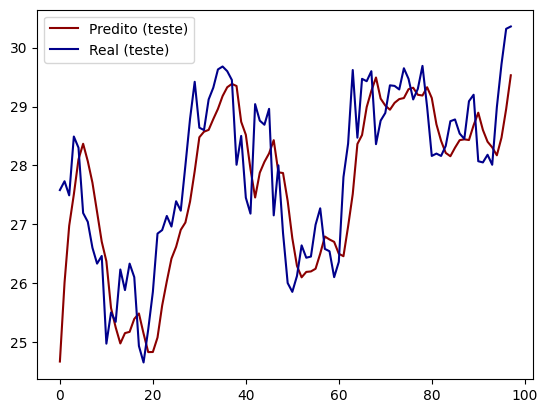

In [19]:
# Plotar resultados
plt.plot(np.ravel(Y_test_pred), label='Predito (teste)', color='darkred')
plt.plot(np.ravel(y_test_real), label='Real (teste)', color='darkblue')
plt.legend()
plt.show()